<a href="https://colab.research.google.com/github/Veniverse/ShAP-Analysis-of-Credit-Risk-Prediction/blob/main/SHAP_Analysis_of_Credit_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import shap
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Load Dataset
data = pd.read_csv('credit_risk_synthetic.csv')  # replace with your CSV path

In [ ]:
# Step 2: Data Preprocessing
# Fill missing values with median (if any)
data.fillna(data.median(), inplace=True)


In [ ]:
# Encode categorical columns
for col in data.select_dtypes(include='object'):
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Define features and target
X = data.drop('target', axis=1)
y = data['target']

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Step 3: Train XGBoost Model

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Step 4: Model Evaluation
# -------------------------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Model Performance Metrics:\nAUC: {auc:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}")


Model Performance Metrics:
AUC: 0.757
Precision: 0.629
Recall: 0.688


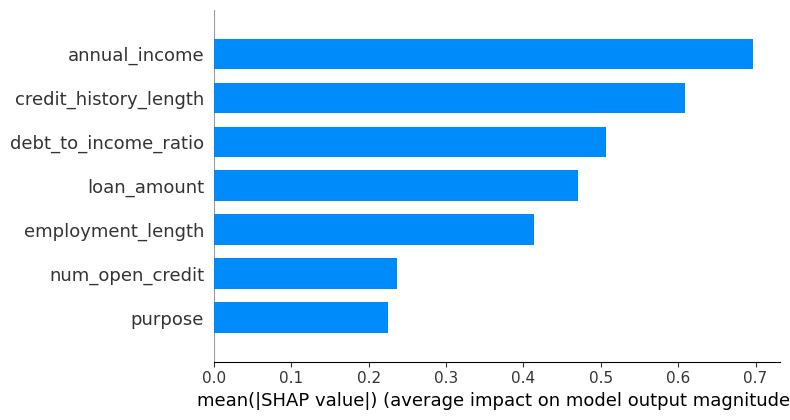

In [ ]:
# Step 5: SHAP Analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")


--- High-Risk Loan Example ---
Predicted risk: 1 (0 = low-risk, 1 = high-risk)


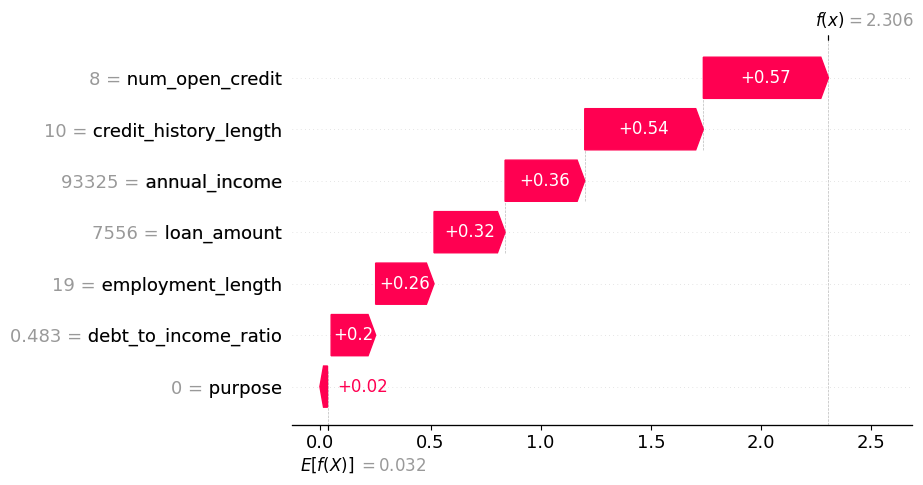

Top 5 influential features for this case:
                 feature  shap_value  abs_shap
3        num_open_credit    0.567808  0.567808
2  credit_history_length    0.538231  0.538231
1          annual_income    0.361536  0.361536
0            loan_amount    0.322484  0.322484
5      employment_length    0.264985  0.264985

--- Low-Risk Loan Example ---
Predicted risk: 1 (0 = low-risk, 1 = high-risk)


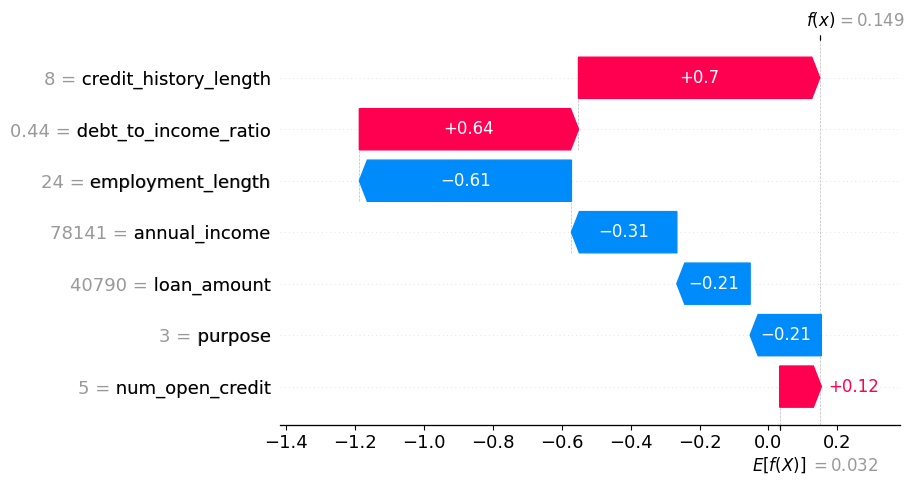

Top 5 influential features for this case:
                 feature  shap_value  abs_shap
2  credit_history_length    0.699576  0.699576
4   debt_to_income_ratio    0.635361  0.635361
5      employment_length   -0.614844  0.614844
1          annual_income   -0.305658  0.305658
0            loan_amount   -0.212572  0.212572

--- Borderline Loan Example ---
Predicted risk: 1 (0 = low-risk, 1 = high-risk)


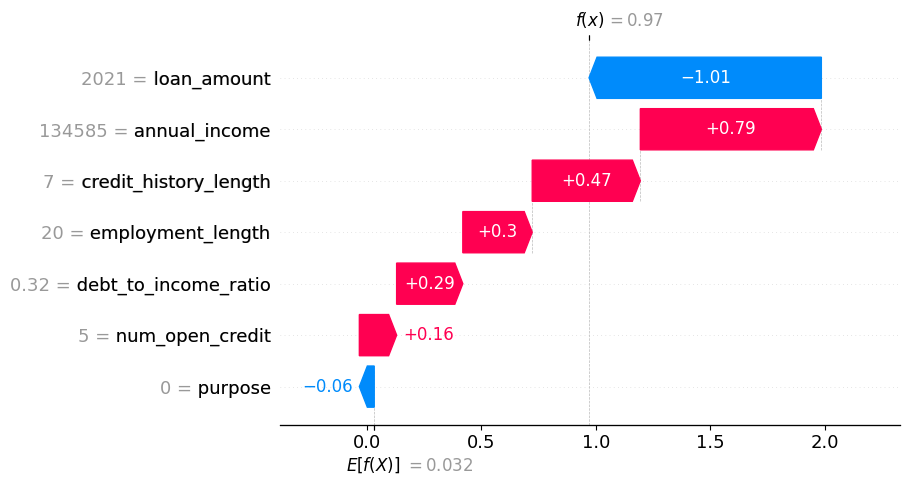

Top 5 influential features for this case:
                 feature  shap_value  abs_shap
0            loan_amount   -1.014049  1.014049
1          annual_income    0.790215  0.790215
2  credit_history_length    0.471977  0.471977
5      employment_length    0.303011  0.303011
4   debt_to_income_ratio    0.288919  0.288919

Generating SHAP dependence plot for top feature: annual_income


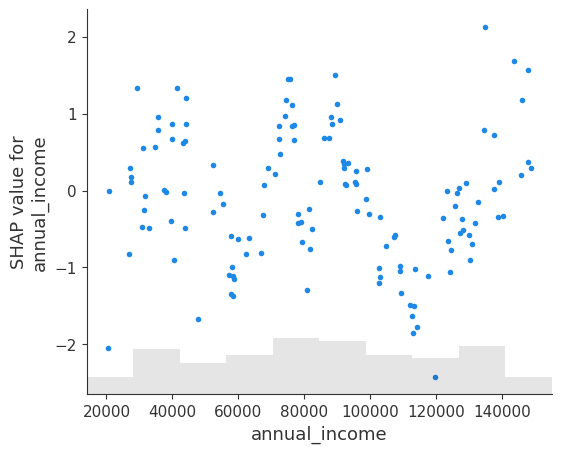

In [ ]:
# -------------------------
# Step 6: Individual Loan Case Explanations
# -------------------------

# Select indices for high-risk, low-risk, and borderline cases
high_risk_idx = 0
low_risk_idx = 1
borderline_idx = 2

# Function to explain a single prediction
def explain_individual_case(idx, description):
    print(f"\n--- {description} ---")
    print(f"Predicted risk: {y_pred[idx]} (0 = low-risk, 1 = high-risk)")

    # SHAP waterfall plot (better for individual explanations)
    shap.plots.waterfall(shap_values[idx])

    # Display top 5 features by absolute SHAP value
    case_shap = pd.DataFrame({
        'feature': X_test.columns,
        'shap_value': shap_values[idx].values
    })
    case_shap['abs_shap'] = case_shap['shap_value'].abs()
    print("Top 5 influential features for this case:")
    print(case_shap.sort_values('abs_shap', ascending=False).head(5))

# Explain each case
explain_individual_case(high_risk_idx, "High-Risk Loan Example")
explain_individual_case(low_risk_idx, "Low-Risk Loan Example")
explain_individual_case(borderline_idx, "Borderline Loan Example")

# SHAP dependence plot for the most important global feature
# Identify top global feature
global_importance = np.abs(shap_values.values).mean(0)
top_feature_idx = np.argmax(global_importance)
top_feature = X_test.columns[top_feature_idx]

print(f"\nGenerating SHAP dependence plot for top feature: {top_feature}")
shap.plots.scatter(shap_values[:, top_feature])


In [ ]:
# Step 7: Insights Summary
# -------------------------
# Calculate global feature importance
global_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

print("\nTop 5 Most Influential Features Globally:")
print(global_importance.head(5))

# Individual case explanations
def explain_case(idx, description):
    print(f"\n--- {description} ---")
    print(f"Predicted risk: {y_pred[idx]}")
    case_shap = pd.DataFrame({
        'feature': X_test.columns,
        'shap_value': shap_values[idx].values
    }).sort_values(by='shap_value', key=abs, ascending=False)
    print(case_shap.head(5))

explain_case(high_risk_idx, "High-Risk Loan Example")
explain_case(low_risk_idx, "Low-Risk Loan Example")
explain_case(borderline_idx, "Borderline Loan Example")


Top 5 Most Influential Features Globally:
                 feature  mean_abs_shap
1          annual_income       0.696742
2  credit_history_length       0.609430
4   debt_to_income_ratio       0.506551
0            loan_amount       0.470168
5      employment_length       0.413421

--- High-Risk Loan Example ---
Predicted risk: 1
                 feature  shap_value
3        num_open_credit    0.567808
2  credit_history_length    0.538231
1          annual_income    0.361536
0            loan_amount    0.322484
5      employment_length    0.264985

--- Low-Risk Loan Example ---
Predicted risk: 1
                 feature  shap_value
2  credit_history_length    0.699576
4   debt_to_income_ratio    0.635361
5      employment_length   -0.614844
1          annual_income   -0.305658
0            loan_amount   -0.212572

--- Borderline Loan Example ---
Predicted risk: 1
                 feature  shap_value
0            loan_amount   -1.014049
1          annual_income    0.790215
2  credit_hi

Cloning into 'water-quality-prediction'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 3.59 MiB | 5.71 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
!git config --global user.name "Veniverse"
!git config --global user.email "veniv3096@gmail.com"


In [ ]:
!git clone !git clone https://github.com/Veniverse/ShAP-Analysis-of-Credit-Risk-Prediction


fatal: Too many arguments.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    --reject-shallow      don't clone shallow repository
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    --recursive ...       alias of --recurse-submodules
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    reference repository
    --refere